<a href="https://colab.research.google.com/github/candiceevemiller/personal-projects/blob/main/EMNIST_Balanced_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.datasets import fetch_openml

emnist = fetch_openml('EMNIST_Balanced')
emnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
X, y = emnist['data'], emnist['target']
X.shape

(131600, 784)

In [3]:
y.shape

(131600,)

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y):
  X_train_full, X_test = X[train_index], X[test_index]
  y_train_full, y_test = y[train_index], y[test_index]

for train_index, val_index in sss.split(X_train_full, y_train_full):
  X_train, X_val = X_train_full[train_index], X_train_full[val_index]
  y_train, y_val = y_train_full[train_index], y_train_full[val_index]

In [5]:
features = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9',
            10:'A', 11:'B', 12:'C', 13:'D', 14:'E', 15:'F', 16:'G', 17:'H', 18:'I',
            19:'J', 20:'K', 21:'L', 22:'M', 23:'N', 24:'O', 25:'P', 26:'Q', 27:'R',
            28:'S', 29:'T', 30:'U', 31:'V', 32:'W', 33:'X', 34:'Y', 35:'Z', 36:'a',
            37:'b', 38:'d', 39:'e', 40:'f', 41:'g', 42:'h', 43:'n', 44:'q', 45:'r',
            46:'t'}

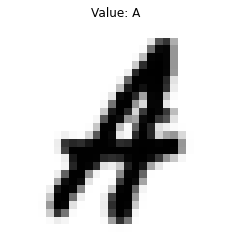

In [6]:
index = np.random.randint(0,X_train.shape[0])
some_char = X_train[index]
some_char_image = some_char.reshape(28,28)
some_char_image = tf.transpose(some_char_image).numpy()
plt.imshow(some_char_image, cmap='Greys')
plt.title(f"Value: {features[int(y_train[index])]}")
plt.axis('off')
plt.show()

In [7]:
from tensorflow.keras import backend as k
img_rows = 28
img_cols = 28
#reshaping
#this assumes our data format
#For 3D data, "channels_last" assumes (conv_dim1, conv_dim2, conv_dim3, channels) while 
#"channels_first" assumes (channels, conv_dim1, conv_dim2, conv_dim3).
if k.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    X_val = X_val.reshape(X_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
#more reshaping
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_val /= 255
X_test /= 255
print('X_train shape:', X_train.shape)

X_train shape: (84224, 28, 28, 1)


In [8]:
y_train = keras.utils.to_categorical(y_train, 47)
y_test = keras.utils.to_categorical(y_test, 47)
y_val = keras.utils.to_categorical(y_val, 47)

In [42]:
model = keras.models.Sequential([
  layers.Conv2D(28, (2,2), kernel_initializer='he_uniform', padding='same', input_shape=(28,28,1)),
  layers.BatchNormalization(),
  layers.Activation('selu'),
  layers.Conv2D(28, (2,2), kernel_initializer='he_uniform', padding='same'),
  layers.BatchNormalization(),
  layers.Activation('selu'),
  layers.MaxPooling2D((2,2)),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Conv2D(56, (2,2), kernel_initializer='he_uniform', padding='same'),
  layers.BatchNormalization(),
  layers.Activation('selu'),
  layers.Conv2D(56, (2,2), kernel_initializer='he_uniform', padding='same'),
  layers.BatchNormalization(),
  layers.Activation('selu'),
  layers.MaxPooling2D((2,2)),
  layers.BatchNormalization(),
  layers.Activation('selu'),
  layers.Dropout(0.2),
  layers.Conv2D(112, (2,2), kernel_initializer='he_uniform', padding='same'),
  layers.BatchNormalization(),
  layers.Activation('selu'),
  layers.Conv2D(112, (2,2), kernel_initializer='he_uniform', padding='same'),
  layers.BatchNormalization(),
  layers.Activation('selu'),
  layers.MaxPooling2D((2,2)),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, kernel_initializer='he_uniform', kernel_regularizer='l2'),
  layers.BatchNormalization(),
  layers.AlphaDropout(0.2),
  layers.Activation('selu'),
  layers.Dense(128, kernel_initializer='he_uniform', kernel_regularizer='l2'),
  layers.BatchNormalization(),
  layers.AlphaDropout(0.2),
  layers.Activation('selu'),
  layers.Dense(47, activation='softmax')
])

In [43]:
INIT_LR = 5e-3
BATCH_SIZE = 2000
EPOCHS = 200

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adamax(learning_rate=INIT_LR), metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('emnistCNN.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [44]:
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    shuffle=True,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/200
43/43 [==============================] - 6s 110ms/step - loss: 4.0011 - accuracy: 0.4795 - val_loss: 3.0449 - val_accuracy: 0.4516
Epoch 2/200
43/43 [==============================] - 4s 103ms/step - loss: 1.2191 - accuracy: 0.7342 - val_loss: 0.8261 - val_accuracy: 0.8021
Epoch 3/200
43/43 [==============================] - 4s 103ms/step - loss: 0.8622 - accuracy: 0.7749 - val_loss: 0.7162 - val_accuracy: 0.8098
Epoch 4/200
43/43 [==============================] - 4s 103ms/step - loss: 0.7455 - accuracy: 0.7969 - val_loss: 0.6844 - val_accuracy: 0.8185
Epoch 5/200
43/43 [==============================] - 4s 103ms/step - loss: 0.6815 - accuracy: 0.8115 - val_loss: 0.6316 - val_accuracy: 0.8265
Epoch 6/200
43/43 [==============================] - 4s 103ms/step - loss: 0.6452 - accuracy: 0.8194 - val_loss: 0.5792 - val_accuracy: 0.8338
Epoch 7/200
43/43 [==============================] - 4s 103ms/step - loss: 0.6186 - accuracy: 0.8261 - val_loss: 0.5109 - val_accuracy: 0.8538

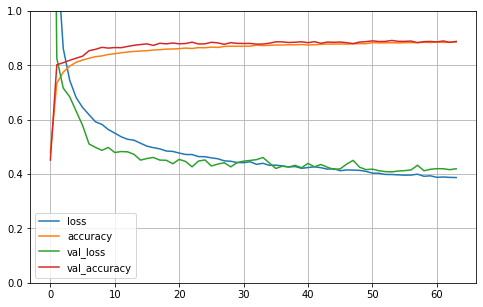

In [47]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.ylim([0,1])
plt.show()

In [29]:
feature_names = []
for i in features:
  feature_names.append(features[i])
feature_names

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'd',
 'e',
 'f',
 'g',
 'h',
 'n',
 'q',
 'r',
 't']

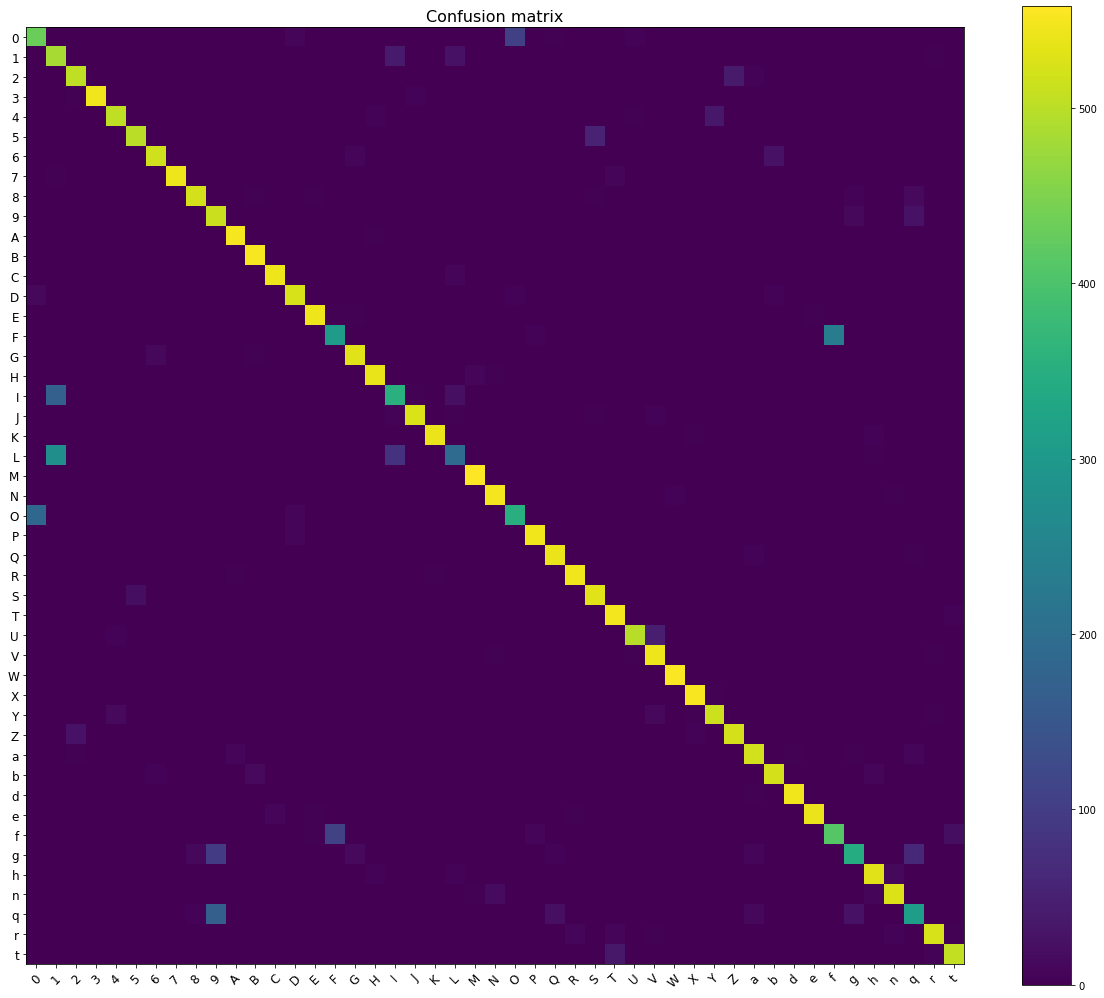

Test accuracy: 0.8904255319148936


In [48]:
# make test predictions
y_pred_test = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = np.array([list(onehot).index(1) for onehot in y_test])

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(21, 18))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(47), feature_names, rotation=45, fontsize=12)
plt.yticks(np.arange(47), feature_names, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))